<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

19:14:09 Starting...
19:14:09 Installing yfinance into Google notebook...
19:14:12 Installing arch into Google notebook...
19:14:20 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [2]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='SPY','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index ETF'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

19:14:20 Fetching data from Yahoo!...


<ipython-input-2-eadee26bc247>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


SPY,Close,High,Low,Open,Volume,Return
Date,,,,,,
1993-02-01,24.700521,24.700521,24.543527,24.543527,480500,0.711268
1993-02-02,24.752848,24.770292,24.630741,24.683072,201300,0.211843
1993-02-03,25.014511,25.031955,24.770297,24.787741,529400,1.057104
1993-02-04,25.119165,25.171497,24.822620,25.101722,531500,0.418374
1993-02-05,25.101719,25.154050,24.962168,25.101719,492100,-0.069455
...,...,...,...,...,...,...
2019-12-23,297.810913,298.209570,297.662570,298.153945,52990000,0.152764
2019-12-24,297.820160,298.089006,297.514193,298.042661,20270000,0.003105
2019-12-26,299.405640,299.414920,298.200389,298.209641,30911200,0.532361


## Fit baseline AR(1) GJR-AGARCH(1,1) model

In [3]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)

19:14:40
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.19
Distribution:      Generalized Error Distribution   AIC:                           17530.4
Method:                        Maximum Likelihood   BIC:                           17571.3
                                                    No. Observations:                 6777
Date:                            Wed, Feb 26 2025   Df Residuals:                     6775
Time:                                    19:14:40   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.062287,0.009115
Return[1],-0.037915,0.013220
omega,0.017251,0.003156
gamma[1],0.187388,0.021783
beta[1],0.888964,0.011779
nu,1.348245,0.036889


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1993-02-01,24.700521,24.700521,24.543527,24.543527,480500,0.711268,NaN,NaN,NaN
1993-02-02,24.752848,24.770292,24.630741,24.683072,201300,0.211843,0.783960,0.035319,NaN
1993-02-03,25.014511,25.031955,24.770297,24.787741,529400,1.057104,0.750735,0.054255,1.279209
1993-02-04,25.119165,25.171497,24.822620,25.101722,531500,0.418374,0.719912,0.022207,0.527706
1993-02-05,25.101719,25.154050,24.962168,25.101719,492100,-0.069455,0.691360,0.046424,-0.160963
...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810913,298.209570,297.662570,298.153945,52990000,0.152764,0.484164,0.045664,0.216689
2019-12-24,297.820160,298.089006,297.514193,298.042661,20270000,0.003105,0.475013,0.056495,-0.110273
2019-12-26,299.405640,299.414920,298.200389,298.209641,30911200,0.532361,0.467300,0.062169,0.989850


## Fit a Basic "Filter Rules" Model

19:14:52 Creating filter rule indicators with order 3 and offset 0.100000.
19:14:52 Fitting GJR-GARCH model with filter rules...
19:14:53
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.08
Distribution:      Generalized Error Distribution   AIC:                           17528.2
Method:                        Maximum Likelihood   BIC:                           17616.8
                                                    No. Observations:                 6773
Date:                            Wed, Feb 26 2025   Df Residuals:                     6764
Time:                                    19:14:53   Df Model:                            9
                                   Mean Mod

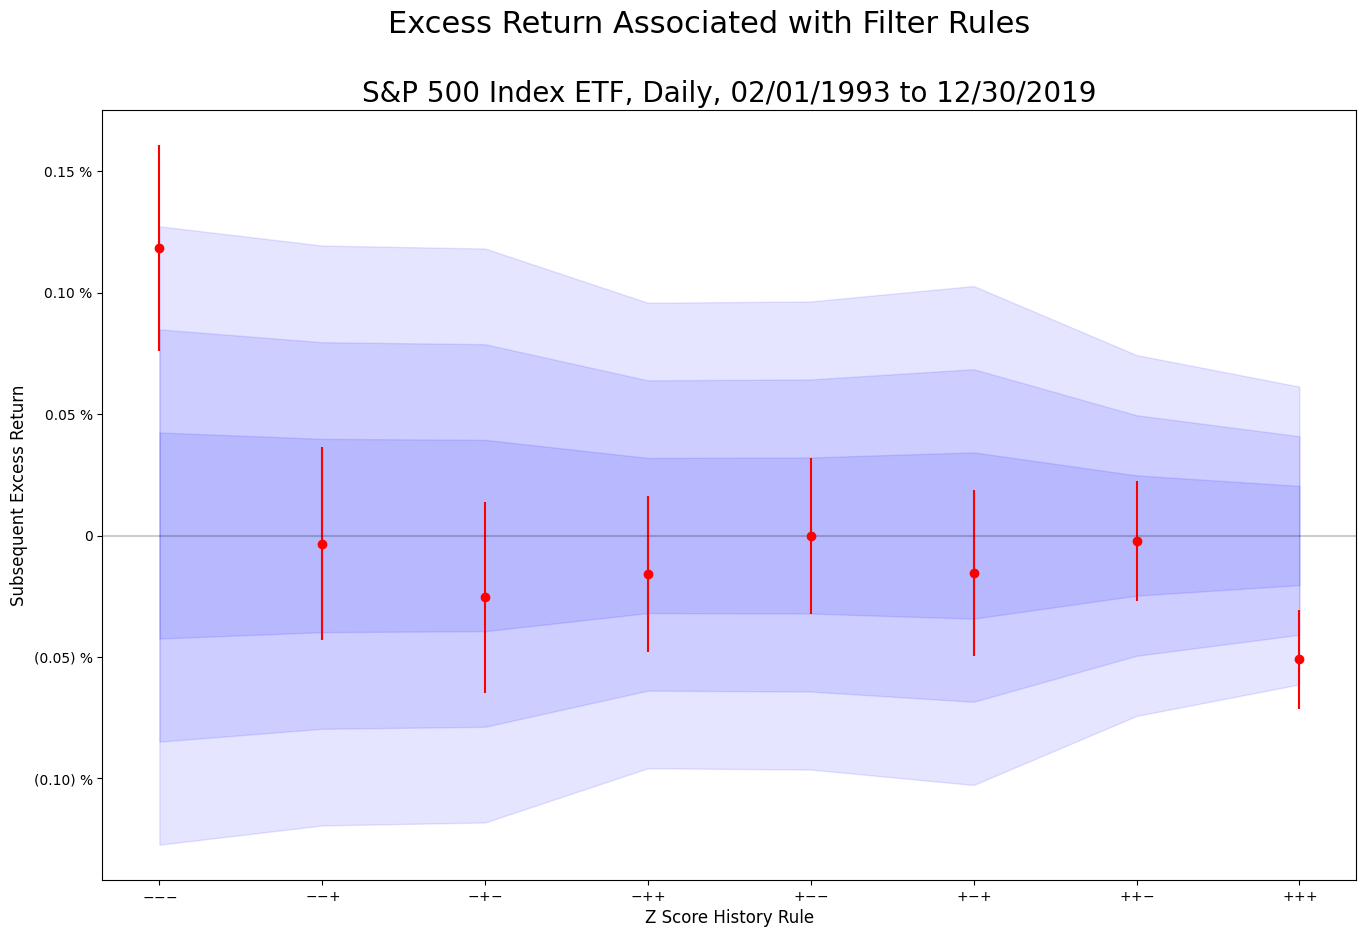

In [4]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=3,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)
data.drop(data.columns[data.columns.str.contains('Filter')],axis=1,inplace=True)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=list(map(lambda l:l.replace('Filter_','').replace('0','$-$').replace('1','$+$'),coefficients.index)),y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to (Filter_000 | Filter_111)

In [17]:
nprint("Fitting a hybrid conditional autoregression...")
data['Filter']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
model=ARX((design:=data.dropna())['Return'],design['Filter'])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return','Conditional']].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return','Conditional']].replace(zero,np.nan).dropna().shape[0]-three)))

19:21:56 Fitting a hybrid conditional autoregression...
19:21:56
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.005
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.40
Distribution:      Generalized Error Distribution   AIC:                           17514.8
Method:                        Maximum Likelihood   BIC:                           17555.7
                                                    No. Observations:                 6773
Date:                            Wed, Feb 26 2025   Df Residuals:                     6771
Time:                                    19:21:56   Df Model:                            2
                                 Mean Model                                 
                 coef    std err       

0.1639404388372486